In [1]:
STIMULUS_SHAPE=(20,20)

import scipy.misc
import numpy as np
from skimage import draw
import math
import matplotlib.pyplot as plt

# From: https://stackoverflow.com/questions/31638651/how-can-i-draw-lines-into-numpy-arrays
def generate_bar(angle, width, off_x=0, off_y=0, inverted=0):
    sz = 100
    center = np.array((sz,sz))
    
    img = np.zeros((sz*5,sz*5))
    for i in range(int(-width/2), int(width/2)+1):

        tlx = int((center[0]) + off_y + sz * math.cos(angle))+i
        tly = int((center[1]) + off_x + sz * math.sin(angle))
        
        brx = int((center[0]) + off_y - sz * math.cos(angle))+i
        bry = int((center[0]) + off_x - sz * math.sin(angle))

        rr, cc = draw.line(tlx, tly, brx, bry)
        img[rr, cc] = 1
        
        
        tlx = int((center[0]) + off_y + sz * math.cos(angle))
        tly = int((center[1]) + off_x + sz * math.sin(angle))+i
        
        brx = int((center[0]) + off_y - sz * math.cos(angle))
        bry = int((center[0]) + off_x - sz * math.sin(angle))+i

        rr, cc = draw.line(tlx, tly, brx, bry)
        img[rr, cc] = 1
        
    img = img[int(center[0] - STIMULUS_SHAPE[0] / 2) : int(center[0] + STIMULUS_SHAPE[0] / 2),
              int(center[1] - STIMULUS_SHAPE[1] / 2) : int(center[1] + STIMULUS_SHAPE[1] / 2)]
#     img[img != 1] = .01
    plt.imshow(img)
    return img

def generate_static():
    return np.ones(STIMULUS_SHAPE) * .2
    

In [2]:
import math

<IPython.core.display.Javascript object>


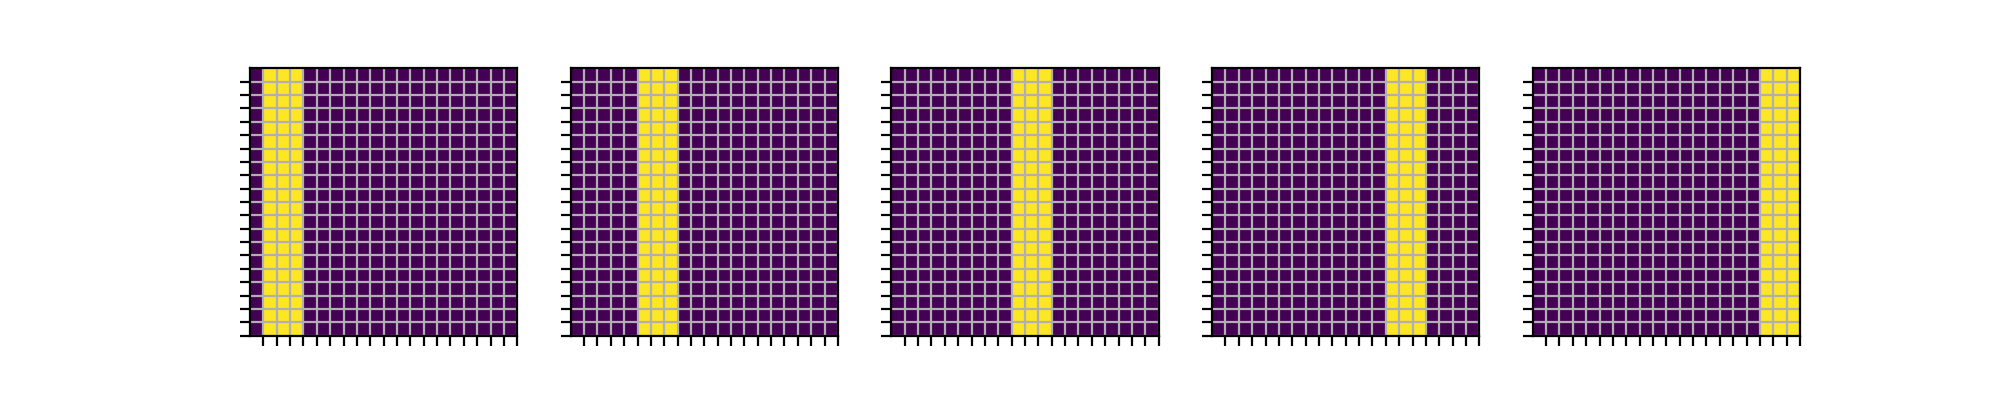

In [24]:


stimuli = []
plt.figure(figsize=(10,2))
plt.subplot(1,5,1)
for i, offset in enumerate([-8, -4, 0, 4, 8]):
    plt.subplot(1, 5, i+1)
    stimuli.append(generate_bar(0, 2, offset))
    plt.grid(which='major')
    plt.xticks(np.arange(20)+.5)
    plt.yticks(np.arange(20)+.5)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])


In [4]:
import brian2 as b
b.set_device('cpp_standalone')

In [5]:

b.prefs.codegen.cpp.extra_compile_args_gcc = ['-w', '-O3', '-ffast-math', '-fno-finite-math-only']

taum = 10*b.ms
taupre = 10*b.ms
taupost = taupre
Ee = 0*b.mV
vt = -54*b.mV
vr = -60*b.mV
El = -74*b.mV
taue = 5*b.ms
F = 15*b.Hz
gmax = .5
dApre = 1.
nu = .2
mu = 2.
Atar = .2
wmax = .055
wmin = .02

In [6]:
eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

In [7]:
N_INPUT = np.product(STIMULUS_SHAPE)
STIMULUS_TIME = 100 # seconds
# N_INPUT=100
def make_changing_input_group(input_array, dt, on_rate = 50 * b.Hz):
    input_values = [x.flatten() * on_rate for x in input_array]
    stimulus = b.TimedArray(input_values, dt=dt)
    PG = b.PoissonGroup(N_INPUT, rates = 'stimulus(t, i)')
    return stimulus, PG

def make_static_input_group(input_matrix, on_rate = 90 * b.Hz):
    input_values = input_matrix.flatten() * on_rate
    print(input_values.shape)
#     print(input_values)
    PG = b.PoissonGroup(N_INPUT, rates = input_values)
    return PG

stimulus, input_group = make_changing_input_group(stimuli, STIMULUS_TIME * b.second, 25.*b.Hz)
# input_group = make_static_input_group(stimuli[0], 60 * b.Hz)
# input_group = b.PoissonGroup(N, rates=15. * b.Hz)

In [8]:
neurons = b.NeuronGroup(1, eqs_neurons, 
                        threshold = 'v > vt', 
                        reset = 'v = vr', 
                        method='exact')
neurons.v = vr

S = b.Synapses(input_group, neurons,
             '''w : 1
                is_clamped : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)''',
             on_pre='''ge += (1 - is_clamped) * w
                    Apre += dApre
                    ''',
             on_post='''
                    w = clip(w + nu*(Apre - Atar) * (wmax - w) ** mu, wmin, wmax)''',
             )
S.connect()
S.Apre = Atar * .5


In [ ]:
run_duration = STIMULUS_TIME * len(stimuli)
S.w = 'wmin'
S.is_clamped = 0
# orig_sw = np.array(S.w).copy()
mon = b.StateMonitor(S, 'w', dt=2*b.second, record=range(N_INPUT))
# s_mon = b.SpikeMonitor(input_group)
v_mon = b.StateMonitor(neurons, 'v', record=[0])
s_mon = b.SpikeMonitor(neurons)
net = b.Network(input_group, S, neurons, v_mon, s_mon, mon)
net.run(run_duration * b.second, report='text')

WARNING    "i" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(v_mon.t, v_mon.v[0]/b.mV)

In [ ]:
weights = mon.w.reshape([STIMULUS_SHAPE[0],STIMULUS_SHAPE[1], -1])
weights.shape

In [ ]:
%matplotlib notebook
plt.figure()
plt.subplot(121)
plt.imshow(np.array(weights[:,:,50]).reshape(STIMULUS_SHAPE))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.array(S.w).reshape(STIMULUS_SHAPE))
plt.colorbar()

In [ ]:
frames = weights.shape[-1]
stim_step = float(len(stimuli)) / frames
step = float(mon.w.shape[1]) / frames
interval = int(10000 / frames)
fr,_ = np.histogram(s_mon.t, run_duration)

w_inds = np.arange(frames) * step
w_frames = mon.w[:,w_inds.astype(int)]
w_frames = w_frames.reshape(STIMULUS_SHAPE[0], STIMULUS_SHAPE[1], frames)

time_step = run_duration / frames

In [ ]:
%matplotlib notebook
from matplotlib import animation, rc
from IPython.display import HTML
fig = plt.figure(figsize=(7,3))
plt.subplot(131)
plt.xticks([])
plt.yticks([])
plt.title("Stimulus")
img1 = plt.imshow(stimuli[0])
plt.subplot(132)
plt.title("Weight")
img2 = plt.imshow(mon.w[:,0].reshape(STIMULUS_SHAPE), vmin=mon.w.min(), vmax=mon.w.max())
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.ylabel("Firing Rate (Hz)")
img3, = plt.plot([0], [0], 'k')
plt.title("Postsynaptic Activity")
plt.xlim([0, run_duration])
plt.ylim([0, max(fr) * 1.2])
plt.xlabel("Time (s)")
plt.tight_layout()



def animate(i):
    img1.set_data(stimuli[int(i * stim_step)])
    img2.set_data(w_frames[:,:,i])
    img3.set_data(range(run_duration)[:int(i*time_step)], fr[:int(i*time_step)])
    
anim = animation.FuncAnimation(fig, animate,
                               frames=frames, interval=interval, 
                               blit=True)
anim.save("Bar_Learning_2.mp4", fps=10)